<a href="https://colab.research.google.com/github/OdysseusPolymetis/ia_et_shs/blob/main/4_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stanza transformers

In [ ]:
import os
import stanza
from lxml import etree as ET
import lxml.html
import string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from transformers import pipeline

In [ ]:
# Utilisation de CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation du pipeline avec le modèle en utilisant CUDA
sentiment_pipe = pipeline(
    "text-classification",
    model="ac0hik/Sentiment_Analysis_French",
    device=0 if torch.cuda.is_available() else -1
)

In [ ]:
!wget https://raw.githubusercontent.com/ebalzac/FC/refs/heads/gh-pages/balzac-22-FC-pere-goriot.xml

In [ ]:
def strip_ns_prefix(tree):
    query = "descendant-or-self::*[namespace-uri()!='']"
    for element in tree.xpath(query):
        element.tag = ET.QName(element).localname
    return tree

In [ ]:
filepath_of_text = "/content/balzac-22-FC-pere-goriot.xml"

In [ ]:
nlp_stanza = stanza.Pipeline(lang='fr', processors='tokenize,mwt')

In [ ]:
parser = ET.XMLParser(remove_blank_text=True, resolve_entities=False, encoding='utf8')
tree = strip_ns_prefix(ET.parse(filepath_of_text, parser))
ps = tree.xpath(".//p")
paragraphs= []
for p in ps:
  sentences = []
  for sentence in nlp_stanza("".join(p.itertext())).sentences:
    sentences.append(sentence.text)
  paragraphs.append(sentences)

In [ ]:
len(paragraphs)

1558

In [ ]:
paragraph_sentiments = []
for paragraph in paragraphs:
    sentence_scores = []
    confidence_scores = []  # Liste pour stocker les scores de confiance

    for sentence in paragraph:
        sentiment = sentiment_pipe(sentence)[0]
        confidence = sentiment['score']
        confidence_scores.append(confidence)

        # Calcul du score de base en fonction de l'étiquette
        if sentiment['label'] == 'negative':
            score = - (confidence - 0.5) * 2  # Score négatif ajusté
        elif sentiment['label'] == 'positive':
            score = (confidence - 0.5) * 2  # Score positif ajusté
        else:  # 'neutral'
            score = 0  # Pas de sentiment

        sentence_scores.append(score)

    # Calcul de la moyenne des scores de sentiment pour le paragraphe
    avg_score = np.mean(sentence_scores)

    # Calcul de la moyenne des scores de confiance
    avg_confidence = np.mean(confidence_scores)

    # Ajustement du score basé sur la longueur du paragraphe
    paragraph_length = len(paragraph)  # Nombre de phrases dans le paragraphe

    # Ajuster l'impact de la longueur et de la confiance de manière plus prononcée
    if paragraph_length > 4:  # Paragraphe long
        adjusted_score = avg_score * (1 + 0.2 * (avg_confidence - 0.5))  # Amplification plus forte
    elif paragraph_length <= 2:  # Paragraphe court
        adjusted_score = avg_score * (1 - 0.2 * (1 - avg_confidence))  # Réduction plus forte
    else:
        adjusted_score = avg_score  # Pas de changement pour les paragraphes de taille moyenne

    paragraph_sentiments.append(adjusted_score)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
indices_to_print = [30, 240, 930]
for index in indices_to_print:
    if index < len(paragraphs):
        paragraph = paragraphs[index]

        full_paragraph = " ".join(paragraph)

        print(f"\nParagraphe {index}:")
        print(full_paragraph)
        print(f"Score moyen de sentiment: {paragraph_sentiments[index]}")

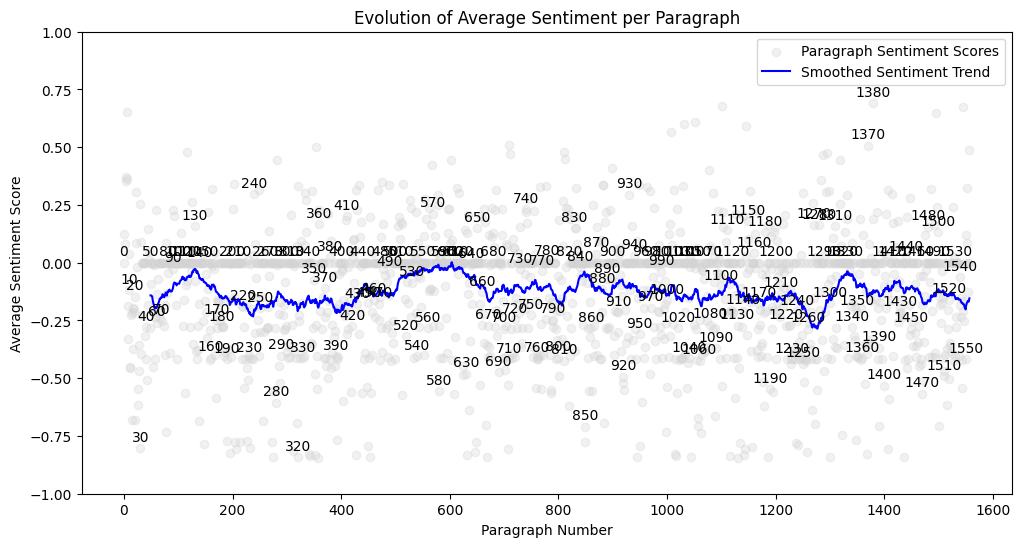

In [ ]:
window_size = 50
smoothed_sentiments = np.convolve(paragraph_sentiments, np.ones(window_size), 'valid') / window_size

plt.figure(figsize=(12, 6))

plt.scatter(range(len(paragraph_sentiments)), paragraph_sentiments, alpha=0.3, color='lightgray', label='Paragraph Sentiment Scores')

plt.plot(range(window_size - 1, len(paragraph_sentiments)), smoothed_sentiments, color='blue', label='Smoothed Sentiment Trend')

plt.ylim(-1, 1)

plt.xlabel('Paragraph Number')
plt.ylabel('Average Sentiment Score')
plt.title('Evolution of Average Sentiment per Paragraph')
plt.legend()

for i, sentiment in enumerate(paragraph_sentiments):
    if i % 10 == 0:
        plt.annotate(str(i), (i, sentiment), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

In [ ]:
def display_paragraphs(indices):
  for i in indices:
    if 0 <= i < len(paragraphs):
      print(f"Paragraph {i}:")
      for sentence in paragraphs[i]:
        print(sentence)
    else:
      print(f"Index {i} is out of bounds.")

display_paragraphs([570])

Paragraph 570:
Depuis cette conversation, le père Goriot vit dans son voisin un confident inespéré, un ami.
Il s’était établi entre eux les seuls rapports par lesquels ce vieillard pouvait s’attacher à un autre homme.
Les passions ne font jamais de faux calculs.
Le père Goriot se voyait un peu plus près de sa fille Delphine, il s’en voyait mieux reçu, si Eugène devenait cher à la baronne.
D’ailleurs il lui avait confié l’une de ses douleurs.
Madame de Nucingen, à laquelle mille fois par jour il souhaitait le bonheur, n’avait pas connu les douceurs de l’amour.
Certes, Eugène était, pour se servir de son expression, un des jeunes gens les plus gentils qu’il eût jamais vus, et il semblait pressentir qu’il lui donnerait tous les plaisirs dont elle avait été privée.
Le bonhomme se prit donc pour son voisin d’une amitié qui alla croissant, et sans laquelle il eût été sans doute impossible de connaître le dénoûment de cette histoire.


In [ ]:
display_paragraphs([1370])

Paragraph 1370:
– Bien, dit-elle en lui prenant la main.
Vous êtes peut-être ici le seul auquel je puisse me fier.
Mon ami, aimez une femme que vous puissiez aimer toujours.
N’en abandonnez aucune.


In [ ]:
display_paragraphs([320])

Paragraph 320:
Madame de Beauséant sourit, mais tristement : elle sentait déjà le malheur qui grondait dans son atmosphère.


In [ ]:
display_paragraphs([230])

Paragraph 230:
– Ah !
bien, sa bêtise est peut-être contagieuse.


In [ ]:
display_paragraphs([840])

Paragraph 840:
– Oh !
Poiret posera en Poiret.
Ce sera le dieu des jardins !
s’écria Vautrin.
Il dérive de poire…


In [ ]:
display_paragraphs([1250])

Paragraph 1250:
Il sanglotait.
Eugène, épouvanté, prit la lettre de change souscrite à Vautrin, et dont le timbre comportait une plus forte somme ;
il en corrigea le chiffre, en fit une lettre de change régulière de douze mille francs à l’ordre de Goriot et entra.


In [ ]:
display_paragraphs([1260])

Paragraph 1260:
–
Tu as tué notre père, Nasie !
dit Delphine en montrant le vieillard évanoui à sa sœur, qui se sauva.


In [ ]:
display_paragraphs([1557])

Paragraph 1557:
Et pour premier acte du défi qu’il portait à la Société, Rastignac alla dîner chez madame de Nucingen.
